# Deep Dive into Analyst Sales

##### Published: Unpublished



## Summary

As of Jan 2015 we have been keeping product level data in SF.  This analysis uses this data, along with seat data from CDB.

For this analysis we should be aware that:

* We only use data from 2015-01-01 onwards for the analysis
* all de-bookings (including Qualcomm). Omitting the de-bookings does over-state bookings to some extent but since many de-bookings are done at the opportunity level rather than at the product level it is a source of error we must accept.
* Line item discounts and traded in products are treated as opportunity level discounts and applied prorata to all products in the opportunity.
* Product allocation in All-You-Can-Eat deals like Ericsson, SAAB and Nokia can lead to overstating the bookings for a product.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xlrd
import dtutil.sfdc as sfdc
from dtutil.accounts import Accounts
sys.path.append('/Users/dane/src/datatools/reports')
from pnhelper import get_product_df
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline
year = '2017'

# Bookings

## Part Number Breakdown

Let's start by looking at the cumulative bookings by product.  This gives us a good indication of which part numbers matter most as well as the relative distribution of customer spending.

Because of our 3-year renewal cycle it makes sense to look at things over a 3-year cycle. Looking at yearly bookings  tends to say more about the large deal renewal cycle than it does actual product sales.  Looking at the cumulative bookings for the trailing 3-years gives a better indication or product performance although it is still impacted by currency fluctuations. For product data, we only have 3-years of data so we do not have sufficient data to do historical comparisons yet.

In [2]:
wod = sfdc.WonOppDict.read_from_file().date_filter('2015-01-01'.format(year), '{}-12-31'.format(year))

# remove opportunities < $0
for k, v in dict(wod).items():
    if v.amt_usd < 0:
        del wod[k]

products = ['ANA_100', 'ANA_001', 'ANA_003', 'ANA_004','ANA_040',
            'ANA_300','MWO_186', 'MWO_286', 'MWO_288', 'MWO_166', 'MWO_266']

sales_dict = wod.sales_by_product()
sales = pd.Series(sales_dict)
print('Gross Bookings of Products including Analyst, 2015-2017 ($K)')
round(sales[products]/1000,0)

Gross Bookings of Products including Analyst, 2015-2017 ($K)


ANA_100     591.0
ANA_001     728.0
ANA_003      36.0
ANA_004     113.0
ANA_040     279.0
ANA_300     463.0
MWO_186     448.0
MWO_286    1730.0
MWO_288     592.0
MWO_166     109.0
MWO_266      86.0
dtype: float64

While this gives us the total bookings of all products that include Analyst it is not that useful because we need to allocate the bookings for the Microwave Office products into their individual product lines.

We have previously come up with an allocation table and for these MWO products.  For example, the Analyst allocation for MWO_186 is 39% while for MWO_288 it is 29%.  Applying these allocations we get these bookings

In [3]:
alloc_dict = {'ANA_100': 1, 'ANA_001': 1, 'ANA_003': 1, 'ANA_004': 1,
                   'ANA_040': 1, 'ANA_300': 1,'MWO_186': .39,
                   'MWO_286': .34, 'MWO_288': .29, 'MWO_166': .42,
                   'MWO_266': .34}
alloc = pd.Series(alloc_dict)
ana_sales = alloc*sales[products]/1000
print('Analyst Product Line Bookings, 2015-2017 ($K)')
round(ana_sales, 0)

Analyst Product Line Bookings, 2015-2017 ($K)


ANA_001    728.0
ANA_003     36.0
ANA_004    113.0
ANA_040    279.0
ANA_100    591.0
ANA_300    463.0
MWO_166     46.0
MWO_186    175.0
MWO_266     29.0
MWO_286    588.0
MWO_288    172.0
dtype: float64

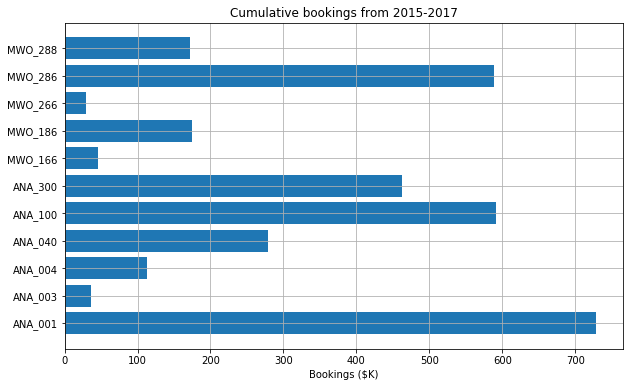

In [4]:
fig = plt.gcf()
fig.set_size_inches(12,1)  
data = ana_sales
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(10,6)     
barh(pos, data, align='center')
yticks(pos, data.index)
xlabel('Bookings ($K)')
title('Cumulative bookings from 2015-{}'.format(year))
grid(True)
show()



## Geographic Breakdown

We can look at the cumulative bookings by territory to get a feel for the geographic distribution.

In [5]:
def get_scaled_product_df(wod, pn_list, scale_factors):
    d = []
    for p in wod.sales_as_dlist():
        if p['base_pn'] in pn_list:
            # scale amt_usd
            p['amt_scaled'] = p['amt_usd'] * scale_factors[p['base_pn']]
            d.append(p)
    return pd.DataFrame(d)
df = get_scaled_product_df(wod, products, alloc_dict)
all_products = pd.DataFrame(wod.sales_as_dlist())
#df.head(1)
#all_products.head(1)

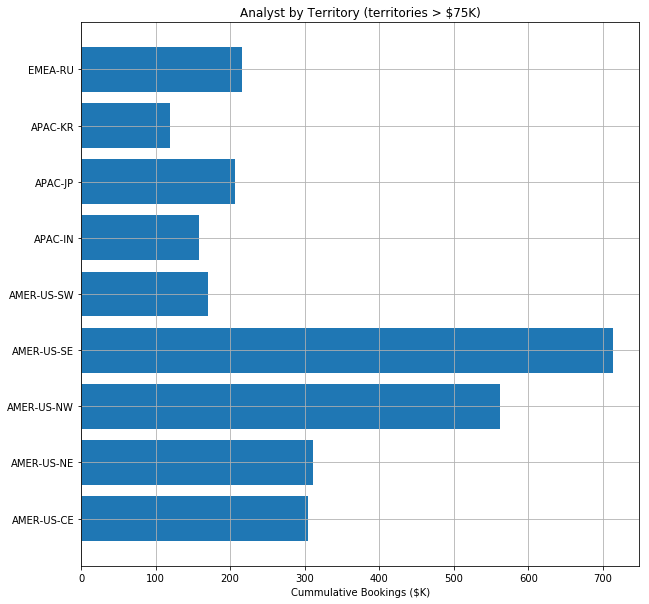

In [6]:
data = df.groupby('territory').amt_scaled.sum() / 1000
fig = plt.gcf()
fig.set_size_inches(10,10)
over = data[data > 75]
pos = np.arange(len(over))
barh(pos, over, align='center')
yticks(pos, over.index)
xlabel('Cummulative Bookings ($K)')
title('Analyst by Territory (territories > $75K)')
grid(True)
show()

This gives a good feel of the size of territories but it can be useful to also have this in tabular form.

##### Bookings by Territory ($K)

Here are the bookings broken down by year and territory as well as the yearly totals.

In [7]:
#print('Bookings by Territory ($K)')
x = df.groupby(['territory', 'close_year']).amt_scaled.sum().unstack().fillna(0) / 1000
x['total'] = x[2015] + x[2016] + x[2017]
np.round(x[x.index != 'Commission Exempt'], 1)

close_year,2015,2016,2017,total
territory,,,,
AMER-CA-E,0.0,0.0,0.3,0.3
AMER-US-CE,33.6,230.1,40.2,303.9
AMER-US-NE,91.1,105.5,115.0,311.6
AMER-US-NW,230.4,162.1,169.3,561.8
AMER-US-SE,118.3,407.3,187.2,712.8
AMER-US-SW,16.2,75.3,79.0,170.5
APAC-AU,0.0,20.5,0.2,20.8
APAC-CN,0.0,10.5,27.9,38.4
APAC-IN,49.3,107.5,1.2,157.9


In [39]:
df.groupby('close_year').amt_scaled.sum() / 1000

close_year
2015     688.086251
2016    1637.925227
2017     892.143279
Name: amt_scaled, dtype: float64

#### Tokens

These booking figures do not include tokens. We have no mechanism to allocate token sales between Axiem and Analyst.  We know we have significantly more Axiem seats than Analyst ones but we have no idea what simulations customers actually run and without that data it is unclear how to allocate token revenue.  The best we can do is acknowledge that there are significant bookings for tokens and that some of those should be allocated to Analyst.  The bookings of tokens per year are:

In [44]:
df = get_scaled_product_df(wod, ['TOK_100'], {'TOK_100': 1.0})
df.groupby('close_year').amt_scaled.sum() / 1000

close_year
2015    228.711376
2016    214.843292
2017    403.890625
Name: amt_scaled, dtype: float64

## Ratio of Analyst Sales to Total Sales

Here we look at, for each territory, what percentage Analyst is of their total sales.  Basically what part of their customer budgets goes to Analyst.

##### Cummulative Bookings and Analyst Ratio for Territories with over 50K in Sales

In [8]:
#print('Cummulative Bookings and VSS Ratio for Territories with over 20K in Sales')
ana = df.groupby('territory').amt_scaled.sum()
all = all_products.groupby('territory').amt_usd.sum()
r = pd.DataFrame(ana) / 1000
r['bookings'] = all / 1000
r['pct_of_terr'] = 100 * (r.amt_scaled / r.bookings)
np.round(r[r.bookings > 500], 1).sort_values('pct_of_terr', ascending=False)

,amt_scaled,bookings,pct_of_terr
territory,,,
AMER-US-NW,561.8,6781.9,8.3
APAC-IN,157.9,1940.7,8.1
AMER-US-SE,712.8,10524.1,6.8
EMEA-RU,216.3,3272.3,6.6
APAC-TW,74.5,1160.7,6.4
AMER-US-CE,303.9,6759.0,4.5
EMEA-IL,61.4,1523.5,4.0
AMER-US-NE,311.6,8979.8,3.5
APAC-JP,206.5,6023.6,3.4


## Product Type

Our healthiest product lines have a good balance between recurring and non-recurring revenue.  Here we see that Analyst has a much higher percentage of term than our our average products.  This is probably a factor of most sales for it being relatively recent when term licenses have been a larger percentage of our sales.

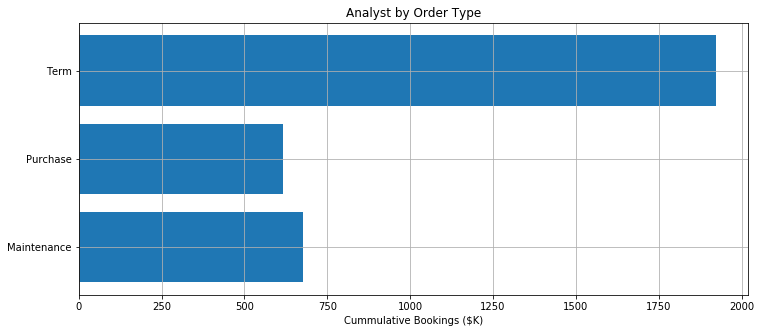

In [9]:
data = df.groupby('order_type').amt_scaled.sum() / 1000
fig = plt.gcf()
fig.set_size_inches(12,5)
pos = np.arange(len(data))
barh(pos, data, align='center')
yticks(pos, data.index)
xlabel('Cummulative Bookings ($K)')
title('Analyst by Order Type')
grid(True)
show()

We can also compute an estimate of the current yearly recurring revenue by taking 1/3rd of the 2015, 2016 and 2017 3-year deals, 1/2 of the 2016 and 2017 2-year deals and all the of 2017 1-year deals. 

In [10]:
tb = df[df.order_type != 'Purchase']
yearly_rr = 0.333 * tb[(tb.years==3)].amt_scaled.sum() +\
            0.500 * tb[(tb.years==2) & ((tb.close_year.isin([2016, 2017])))].amt_scaled.sum() +\
            1.000 * tb[(tb.years==1) & (tb.close_year == 2017)].amt_scaled.sum()
avg_perp = df[df.order_type == 'Purchase'].amt_scaled.sum() / 3.0
print('Yearly Time Based Revenue Run Rate = ${:,}'.format(int(yearly_rr)))
print('Average Yearly Perpetual Revenue = ${:,}'.format(int(avg_perp)))
print('Estimated Yearly Run Rate = ${:,}'.format(int(yearly_rr) + int(avg_perp)))

Yearly Time Based Revenue Run Rate = $889,912
Average Yearly Perpetual Revenue = $205,529
Estimated Yearly Run Rate = $1,095,441


One caveat here is that this assumes that we've reached some form of steady-state and sales of Analyst have not so this should be considered a low estimate.  We will have a much better feel for this once we have one more year of data.


## Bookings by License Type

Over the last few years we have seen WAN licenses increase in our largest customers. It's interesting to note that 25% of our VSS customers still use locked licenses.

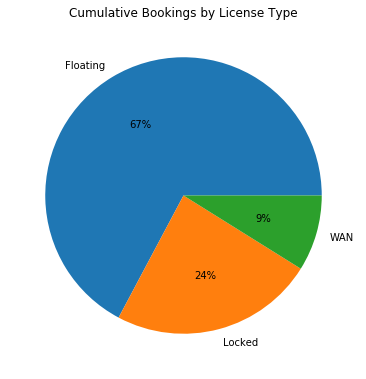

In [11]:
bt = df.groupby('license_type')
x=bt.agg(sum).amt_scaled
plt.figure(1, figsize=(6,6))
plt.axes([0.1, 0.1, 0.8, 0.8])
plt.pie(x, labels=x.index, autopct='%1.0f%%')
plt.title('Cumulative Bookings by License Type'.format(year))
plt.show()

Breaking this down by continent we see that this is driven in part by the large locked license use in APAC.

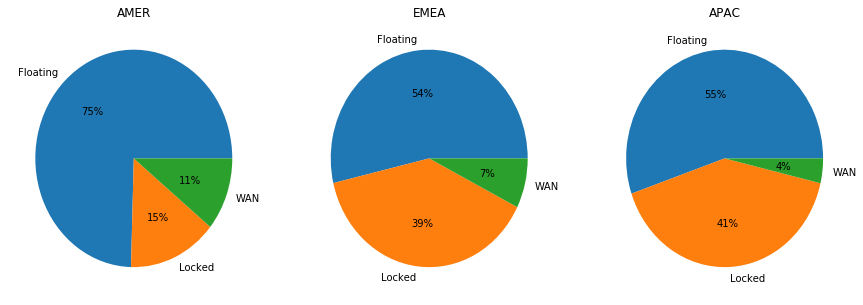

In [12]:
df['continent'] = df.territory.apply(lambda x: x[:4])
# collapse WAN into 1 category
mask = df.license_type.isin(['WAN 1 Timezone', 'WAN 3 Timezones', 'WAN 4 Timezones', 'WAN Worldwide'])
df.loc[mask, 'license_type'] = 'WAN'
btc = df.groupby(['continent','license_type']).agg(sum).amt_scaled
plt.figure(1, figsize=(15,5))
sp=1
for continent in ['AMER', 'EMEA','APAC']:
    plt.subplot(1,3,sp) # numrows, numcols, fignum
    sp += 1
    plt.pie(btc[continent], labels=btc[continent].index, autopct='%1.0f%%')
    plt.title('{}'.format(continent))
plt.show()

## Largest Customers

We can rank the customers by their total 3-year spend on Analyst products.

##### Largest VSS customers, cumulative bookings in ($K)

In [13]:
a = Accounts()
s = df.groupby('custid').amt_scaled.sum() / 1000
x = pd.DataFrame(s)
x['name'] = x.index.map(lambda x: a.get_name(int(x)))
np.round(x.sort_values(by='amt_scaled', ascending=False)[:10][['name', 'amt_scaled']], 1)
#x.head()

,name,amt_scaled
custid,,
665,Qorvo - TQ Hilsboro,526.9
10029,Naval Research Laboratory (NRL) - Vacuum Elect...,301.1
9625,L-3 Communications - Electron Devices,246.0
9632,"Communications & Power Industries, Inc. (CPII)...",174.7
9121,"MACOM Technology Solutions, Inc. - MA",115.6
6586,Research Centre Immarat (RCI),79.9
9975,"Beam Wave Research, Inc. - MD",72.0
11718,Humatics Corporation,71.0
9244,TDK-Corporation - Konoura Plant,68.0


# Non-Renewal Business

As we know, bookings includes both renewal business and non-renewal business.  We define New Business as the non-renewal business plus the growth in renewals but often the growth in renewals, while important, is very hard to determine. It is fairly staightforward to look at the non-renewal business.  All non-renewal business should be new business (except in the case of early respins which are often mis-classified).  The benefit of looking at non-renewal business is that it is a component of new business that is not affected by renewal cycles so it can be compared year-to-year to see if it is improving.

##### Non-renewal by year

In [14]:
for k, v in wod.copy().items():
    if v.renewal or (k == '0063900000qJDk3AAG'):  # delete qualcomm as it is a renewal
        del wod[k]
nr_df = get_scaled_product_df(wod, products, alloc_dict) 
np.round(nr_df.groupby('close_year').amt_scaled.sum() / 1000,0)

close_year
2015    261.0
2016    608.0
2017    356.0
Name: amt_scaled, dtype: float64

##### Non-renewal by territory

In [15]:
x = nr_df.groupby(['territory', 'close_year']).amt_scaled.sum().unstack().fillna(0) / 1000
x['total'] = x[2015] + x[2016] + x[2017]
np.round(x[x.index != 'Commission Exempt'], 1)

close_year,2015,2016,2017,total
territory,,,,
AMER-US-CE,25.1,8.4,21.8,55.3
AMER-US-NE,36.8,31.9,106.0,174.7
AMER-US-NW,15.6,22.3,0.0,37.9
AMER-US-SE,19.5,68.2,15.8,103.4
AMER-US-SW,16.2,20.6,46.8,83.6
APAC-CN,0.0,0.0,24.4,24.4
APAC-IN,49.3,94.0,0.0,143.3
APAC-JP,34.2,34.5,33.9,102.6
APAC-KR,0.0,80.2,6.7,86.9


In the western US the booking goal allows us to further break up the sales so it's worth looking at those also.

##### Non-renewal by US booking goal

In [16]:
x = nr_df.groupby(['booking_goal', 'close_year']).amt_scaled.sum().unstack().fillna(0) / 1000
x['total'] = x[2015] + x[2016] + x[2017]
np.round(x[x.index.isin(['NA-NE', 'NA-SE', 'NA-TX', 'NA-WJS', 'NA-WVJ'])], 1)

close_year,2015,2016,2017,total
booking_goal,,,,
NA-NE,36.8,31.9,106.0,174.7
NA-SE,19.5,68.2,15.8,103.4
NA-TX,25.1,8.4,21.8,55.3
NA-WJS,7.8,13.5,17.4,38.7
NA-WVJ,23.9,29.4,29.4,82.7


# Seats by Product

So far we have only looked at the bookings per product but it is also useful to look at the seats of products.  Of special interest is looking at how many seats of a product are off maintenance as this often indicates customers that have stopped using the product.

##### Number of licensed seats

In [29]:
from dtutil.sqltools import query_to_dataframe, get_cursor_from_url, list_to_query_list
cursor = get_cursor_from_url()

In [31]:
query = """
select * from cdb_custdb
    where partno in {}
        and date = '{}-01-01' and licensed=True 
        and ptype not in ('Loan', 'Home Use')
        and sitetype not in ('NI Academic', 'University')
""".format(list_to_query_list(products), int(year)+1)
seats = query_to_dataframe(cursor, query)
# seats.head()

In [32]:
#print('Number of licensed seats')
seats['maintenance'] = 'off'
seats.loc[seats.version=='13.0', 'maintenance'] = 'on'
nls = seats.groupby(['partno', 'maintenance']).qty.sum().unstack().fillna(0)
nls['pct_on_maint'] = np.round(100 * nls['on'] / (nls['off'] + nls['on']), 1)
nls

maintenance,off,on,pct_on_maint
partno,,,
ANA_001,2.0,67.0,97.1
ANA_004,0.0,4.0,100.0
ANA_040,0.0,10.0,100.0
ANA_100,2.0,9.0,81.8
ANA_300,0.0,10.0,100.0
MWO_166,0.0,3.0,100.0
MWO_186,1.0,6.0,85.7
MWO_266,0.0,2.0,100.0
MWO_286,2.0,24.0,92.3


The great news here is that people that have analyst keep it on maintenance.

## Growth in Licenses

It is also instructive to look at the number of licenses that are active in each country over time.  This allows us to see which countries are increasing their use of Analyst and which are going the wrong direction. For this analysis we will only look at the front-end seats.

##### Total Licensed Seats on Date

In [36]:
products = ['ANA_001', 'ANA_300','MWO_186', 'MWO_286', 'MWO_288', 'MWO_166', 'MWO_266']
query = """
select date, country, sum(qty) as qty from cdb_custdb
    where partno in {}
        and date like '%-01-01'
        and licensed=True 
        and ptype not in ('Loan', 'Home Use')
        and sitetype not in ('University', 'NI Academic')
group by date, country
order by country, date
""".format(list_to_query_list(products))
lic_by_year = query_to_dataframe(cursor,query)
#lic_by_year.head()

In [37]:
# print('Total Licensed Seats on Date')
pd.pivot_table(lic_by_year, index=['country'], columns=['date'], values=['qty'], aggfunc=[sum], fill_value=0)

sum                                 
               qty                                 
date    2015-01-01 2016-01-01 2017-01-01 2018-01-01
country                                            
AU               1          1          2          2
CA               2          1          0          0
CN               1          1          0          2
CZ               1          1          1          1
DE               0          0          0          1
FI               0          0          2          2
FR               1          2          4          4
GB               0          1          1          1
IE               1          1          2          2
IL               0          1          1          3
IN               1          2          7          7
JP               1          4          5          7
KR               5          6          8          7
NL               1          0          0          0
NO               1          1          1          2
RU               1          1          4          6
SE               1          1          1          0
TW               2          2          4          5
US              34         45         63         72

We can also summarize this to totals by year.

##### Worldwide Licensed Seats on Date

In [38]:
# print('Worldwide Licensed Seats on Date')
lic_by_year.groupby('date').qty.sum()

date
2015-01-01     54
2016-01-01     71
2017-01-01    106
2018-01-01    124
Name: qty, dtype: int64